In [2]:
# This program will bring in data, manipulate it, and perform some basic analysis

# For this analysis, I will be looking at some biostatistics data from the following URL
# http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets
# Data is from a Stress Echocardiography study conducted by UCLA
# Full Description available here: 
#    http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/stressEcho.html

# Objective of original study was to predict cardiac events via treatment with a drug
# called dobutamine.  Dobutamine simulates the impact heavy exercise upon the heart, within a 
# population that may not otherwise be able to conduct heavy exercise

# There are four classes of cardiac event that we may wish to predict
# myocardial infarction (MI) - coded: newmi 
# revascularization by percutaneous transluminal coronary angioplasty (PTCA) - coded: newptca
# coronary artery bypass grafting surgery (CABG) - coded: newcabg
# cardiac death - coded: death

In [37]:
# Import third-party modules

%matplotlib inline 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import scipy as sp

from scipy import stats as st
from pandas.tools.plotting import scatter_matrix
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [2]:
# Read in the data
stress = pd.read_csv('/Users/Philip/Documents/Python Scripts/progs/python_scripts/freestyle_eda/input/stressEcho.csv')

# Take a verifying look at this data
print stress.__class__ # make sure it's a pd.df
print "\n"
print stress.head(n = 4) 
colnames = list(stress.columns.values) 
#print out the column names
print colnames

<class 'pandas.core.frame.DataFrame'>


   Unnamed: 0  bhr  basebp  basedp  pkhr  sbp     dp  dose  maxhr  pctMphr  \
0           1   92     103    9476   114   86   9804    40    100       74   
1           2   62     139    8618   120  158  18960    40    120       82   
2           3   62     139    8618   120  157  18840    40    120       82   
3           4   93     118   10974   118  105  12390    30    118       72   

     ...      newCABG  death  hxofHT  hxofDM     hxofCig  hxofMI  hxofPTCA  \
0    ...            0      0       0       0  non-smoker       1         1   
1    ...            0      0       0       1  non-smoker       1         0   
2    ...            0      0       0       1  non-smoker       1         0   
3    ...            0      0       0       0  non-smoker       0         0   

   hxofCABG  any.event        ecg  
0         0          0     normal  
1         0          1  equivocal  
2         0          1  equivocal  
3         0          0     normal 

In [5]:
# Before conducting any specific analysis, let's get a general picture of what we have

tot_summ = stress.describe()
print tot_summ.shape
with pd.option_context('display.max_rows', 10, 'display.max_columns', 50):
    print tot_summ

# note that one feature of this data is that binary indicators code '0' as an event

(8, 29)
       Unnamed: 0         bhr      basebp        basedp        pkhr  \
count  558.000000  558.000000  558.000000    558.000000  558.000000   
mean   279.500000   75.290323  135.324373  10181.313620  120.550179   
std    161.224998   15.415197   20.770106   2579.749367   22.567835   
min      1.000000   42.000000   85.000000   5000.000000   52.000000   
25%    140.250000   64.000000  120.000000   8400.000000  106.250000   
50%    279.500000   74.000000  133.000000   9792.000000  122.000000   
75%    418.750000   84.000000  150.000000  11663.250000  135.000000   
max    558.000000  210.000000  203.000000  27300.000000  210.000000   

              sbp            dp       dose       maxhr     pctMphr  \
count  558.000000    558.000000  558.00000  558.000000  558.000000   
mean   146.915771  17633.844086   33.75448  119.369176   78.569892   
std     36.529544   5220.533978    8.13479   21.907179   15.121101   
min     40.000000   5100.000000   10.00000   58.000000   38.000000   
25

In [6]:
# There are 4 potential outcome variables as mentioned in the header - 
# let's see what these look like 
print("New Myocardial Infarction: \n")
print stress['newMI'].value_counts()
print("\n New Angioplasty: \n")
print stress['newPTCA'].value_counts()
print("\n New Bypass Surgery: \n")
print stress['newCABG'].value_counts()
print("\n Death: \n")
print stress['death'].value_counts()

New Myocardial Infarction: 

0    530
1     28
Name: newMI, dtype: int64

 New Angioplasty: 

0    531
1     27
Name: newPTCA, dtype: int64

 New Bypass Surgery: 

0    525
1     33
Name: newCABG, dtype: int64

 Death: 

0    534
1     24
Name: death, dtype: int64


In [7]:
# how many of these overlap? - summarize

overlap = stress['newMI'] + stress['newPTCA'] + stress['newCABG'] + stress['death']
print overlap.value_counts()

# Verify with the any.event field
print stress['any.event'].value_counts()
# Very close

0    468
1     71
2     16
3      3
dtype: int64
0    469
1     89
Name: any.event, dtype: int64


count    558.000000
mean      67.344086
std       12.049415
min       26.000000
25%       60.000000
50%       69.000000
75%       75.000000
max       93.000000
Name: age, dtype: float64


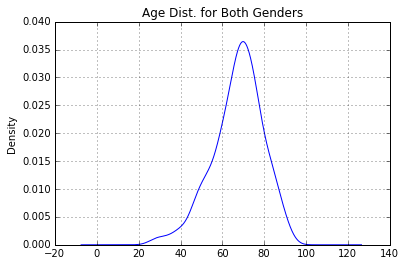

In [8]:
# Now, let's get a look at how this breaks down demographically - start with age and gender

# Tukey Five-Figure Summary for age
print stress['age'].describe()
# Plot the distribution for age
age_plot = stress['age'].plot(kind='kde', title='Age Dist. for Both Genders', grid=True )

<class 'pandas.core.series.Series'>


female    338
male      220
Name: gender, dtype: int64


We have 220 cases in the male dataset
We have 338 cases in the female dataset



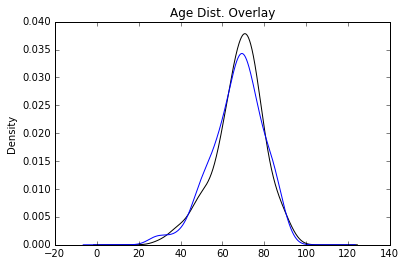

In [9]:
# Now let's see the gender breakdown, and if age varies by gender
print stress['gender'].__class__
print "\n"
print stress['gender'].value_counts()
print "\n"

# Limit down to just the men
men = stress[stress['gender'] == 'male' ]
women = stress[stress['gender'] == 'female' ]

print "We have " + str(men.shape[0]) + " cases in the male dataset"
print "We have " + str(women.shape[0]) + " cases in the female dataset\n"

# let's get KDEs of age for both
men['age'].plot(kind='kde', title='Age Dist. Overlay', grid=True, color='k') #black
women['age'].plot(kind='kde', color='b') #blue



In [10]:
# These look highly similar and roughly normal - let's do a t-test
# conduct Levene's test for equality of variances

# Create a function to perform the t-test
def ttest_procedure(samp1, samp2):
    print st.levene(samp1, samp2)
    levene_p = st.levene(samp1, samp2)[1]
    
    # If we have evidence of a difference in variance equalities
    if levene_p < 0.05: 
        print "\nEvidence of Different Variances\n"
        print st.ttest_ind(samp1, samp2, equal_var=False)
    # If we have no evidence of a difference in variance equalities
    else:
        print "\nNo Evidence of Different Variances\n"
        print st.ttest_ind(samp1, samp2, equal_var=True)

# Run the function
ttest_procedure(men['age'], women['age'])
# No evidence of a difference in age across gender

LeveneResult(statistic=1.0580184350023911, pvalue=0.30411482569983866)

No Evidence of Different Variances

Ttest_indResult(statistic=0.81429937705846644, pvalue=0.41582208453194724)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B254278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C4857B8>]], dtype=object)

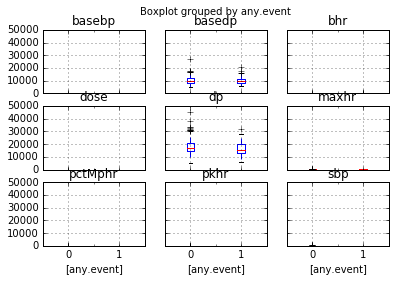

In [11]:
# To get an idea of how some data attributes might correspond to a potential outcome
# variable (will use any.event), let's create some scatterplots
# will have to do this iteratively

test = colnames[1:10]
test.insert(0,'any.event')
sub = stress[test]

sub.boxplot(by='any.event')


In [3]:
#___________________________
#___________________________
#___________________________
# Going to begin making several models to predict an event
# Will be starting with something very simple and working up in complexity
# In predicting 'any.event',  remember that 0 counts as an event 

# Let's think about the variables that we would like to include in our design matrix,
# and remove anything that doesn't make sense - if we need to recode anything, do it here

# gender will require recoding to a single binary variable
stress['male_fl'] = np.where(stress['gender']=='male', 1, 0)
# check
print pd.crosstab(stress['male_fl'], stress['gender'])

# recode any.event so that an event=1 and non-event=0
stress['response'] = np.where(stress['any.event']==0, 1, 0)
print pd.crosstab(stress['any.event'], stress['response'])

# Drop what we don't need
stress.drop(['Unnamed: 0', 'gender', 'newMI', 'newPTCA', 'newCABG', 'death', 'hxofCig', 'ecg', 'any.event'], axis=1, inplace=True)

#stress.drop('colname', axis=1, inplace=True)
#stress_b = stress.drop(['Unnamed: 0', 'newMI', 'newPTCA', 'newCABG', 'death', 'any.event'], 1)
colnames = list(stress.columns.values) 
print colnames

gender   female  male
male_fl              
0           338     0
1             0   220
response    0    1
any.event         
0           0  469
1          89    0
['bhr', 'basebp', 'basedp', 'pkhr', 'sbp', 'dp', 'dose', 'maxhr', 'pctMphr', 'mbp', 'dpmaxdo', 'dobdose', 'age', 'baseEF', 'dobEF', 'chestpain', 'restwma', 'posSE', 'hxofHT', 'hxofDM', 'hxofMI', 'hxofPTCA', 'hxofCABG', 'male_fl', 'response']


In [4]:
# Split the data frame into training and testing (0.6 / 0.4)
stress_train = stress.sample(frac=0.6, random_state=1738)
stress_test = stress.drop(stress_train.index)
# verify
print stress.shape
print stress_train.shape
print stress_test.shape

# Stratification checks - using our favorite demographic variables
# check proportional differences of gender
print stress_train['male_fl'].value_counts()
print stress_test['male_fl'].value_counts()

print stress_train['age'].describe()
print stress_test['age'].describe()



(558, 25)
(335, 25)
(223, 25)
0    202
1    133
Name: male_fl, dtype: int64
0    136
1     87
Name: male_fl, dtype: int64
count    335.000000
mean      67.170149
std       12.068331
min       29.000000
25%       60.000000
50%       69.000000
75%       75.000000
max       93.000000
Name: age, dtype: float64
count    223.000000
mean      67.605381
std       12.043329
min       26.000000
25%       60.000000
50%       69.000000
75%       76.000000
max       92.000000
Name: age, dtype: float64


In [5]:
# Now, create the design matrix and output vector (this is how scikit-learn requires the data)
stress_X_train = stress_train.drop(['response'], axis=1)
stress_Y_train = stress_train['response']

stress_X_test = stress_test.drop(['response'], axis=1)
stress_Y_test = stress_test['response']


In [28]:
# Let's first build a model for explanatory purposes, and focus on the model 
# rather than reducing an error metric.  Nothing fancy for this - no transformations, interactions,
# or algorithmic selection

slr = smf.ols('response ~ dp + dose + restwma + posSE + hxofDM + hxofMI + male_fl', data=stress_train).fit()
print slr.summary()

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     8.051
Date:                Tue, 14 Feb 2017   Prob (F-statistic):           6.37e-10
Time:                        21:24:24   Log-Likelihood:                -107.45
No. Observations:                 335   AIC:                             232.9
Df Residuals:                     326   BIC:                             267.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7257      0.114      6.354      0.0

In [30]:
# Not the best model, but passes the F-test and has some significant terms
# let's do diagnostics
#shapiro-wilk test for straightness of the normal reference distribution line
sp.stats.shapiro(slr.resid)
# returns test-stat, p-value

# p-value indicates that our residuals are quite different from a normal dist.
# let's see if they at least appear normally distributed

(0.8064796328544617, 1.0535618516328918e-19)

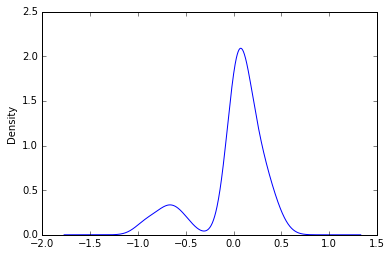

In [31]:
slr.resid.plot(kind='kde', title="Residual Density Estimate" )
# Issue is apparent - probably due to a few observations in particular

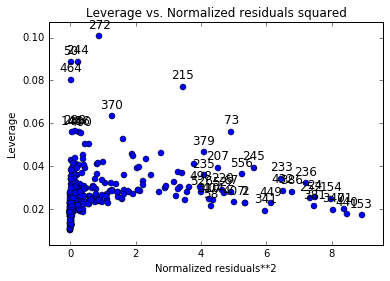

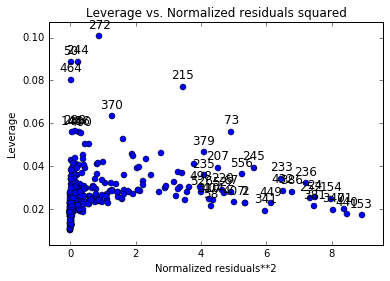

In [35]:
# Because of the small sample we have here, we can assess influence via leverage plots
plot_leverage_resid2(slr)
# Im imagining that the high-influence points correspond to the alternative mode in 
# the residual plot above

In [39]:
# hetereoskedasticity test
sms.het_breushpagan(slr.resid, slr.model.exog)
# returns {lagrange stat, lagrange p-value, f-stat, f-stat p-value}
# model not looking good

(49.996226491346164,
 4.0935883498868071e-08,
 7.1484886127674176,
 1.0007076613291824e-08)

In [40]:
# Now, lets move on to raw predictions using more algorithmic techniques

# First GLM example - simple linear regression - using gaussian link function
# will not be evaluating regression diagnostics at this point, just predictive power
# using RMSE as the primary metric for this
#slr = sk.linear_model.LinearRegression()
#print slr.fit(stress_X_train, stress_Y_train)
#print np.sqrt(np.mean((slr.predict(stress_X_test) - stress_Y_test) ** 2))


In [ ]:
# Next GLM example - logistic regression - using logistic link function
logit = sk.linear_model.LogisticRegression()
print logit.fit(stress_X_train, stress_Y_train)
print np.sqrt(np.mean((logit.predict(stress_X_test) - stress_Y_test) ** 2))

In [ ]:
# Ensemble example - random Forest - not going to optimize the hyperparameters,
# just going to pick arbitrary values for trees and features per tree
